<a href="https://colab.research.google.com/github/Foxy1987/neuroGLM/blob/master/how_to_fit_1DCNN_to_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: 1D convolutional neural networks
__Content creator:__ David Fox


Here we will use a convolutional neural network (CNN) to predict an animal's response to an olfactory stimulus based on its responses to prior stimuli.


Although traditionally developed for two-dimensional image data, CNNs can be used to model univariate time series forecasting problems. Examples include predicting air pollution tomorrow, given the air pollution and atmospheric variables 6 months ago.

Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.

# Import package and libraries

In [75]:
#@title Clone the github repository 
!git clone https://github.com/Foxy1987/neuroGLM
%cd neuroGLM


Cloning into 'neuroGLM'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 344 (delta 191), reused 194 (delta 88), pack-reused 0
Receiving objects: 100% (344/344), 4.78 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/neuroGLM/neuroGLM/neuroGLM


In [76]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [77]:
#@title import modules
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from cnn.preprocessing import preprocess
import cnn.utils
import cnn.create_model
from keras.models import load_model
from sklearn.linear_model import Ridge
from cnn.create_model import r_square
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from glmtools.fit import neg_log_lik, ridgefitCV, fit_nlin_hist1d


In [78]:
#@title housekeeping
np.random.seed(42)

# CNN hyperparameters
batch_size = 64
epochs = 200
input_shape = [750, 1]
print_summary = False

# dir
dirs = dict()
dirs['save'] = 'results/'

if not os.path.exists(dirs['save']):
	os.makedirs(dirs['save'])
if not os.path.exists(dirs['save'] + 'weights'):
	os.makedirs(dirs['save'] + 'weights')


# load the data

In [79]:
behaviors = ["angvturns", "vmoves", "vymoves"]
behavior_par = behaviors[2]

# load the data from MATLAB .mat file
stim, response = io.load_behavior('datasets/behavior/control_behavior.mat', 30., 55., behavior_par, 50)
response = response.mean(axis=1)  # work on the fly-average
stim = stim[:, 0]

#Data preprocessing
Before we can model the time series, we must transform the data. The following transforms are performed on nthe dataseet prior to fitting a model to learn a temporal filter and make a forecast about future changes in the time series:


1.   Transform the time series into a supervised learning problem. Specifically, the timeseries is organized into input and output patterns where the observations at the previous time steps are used as inputs to predict the observation at the current time step. A nice function for doing this can be found here https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
2.   Transform the input and output. Specifically, rescale the inputs to have zero-mean annd unit variance and rescale the outputs to values between 0 and 1 to meet either the linear or sigmoid functions.







# process the time series (transform to supervised learning problem and rescale inputs and outputs)



In [80]:
# preprocess for the CNN to work. This is a VERY important step!
stim_train, stim_test, resp_train, resp_test = preprocess(stim, response, input_shape)


# visualize the train and test design matrices
Here the first 80% of the time series forms the training data and the last 20% forms the test data. 

Here the shape of the matrix is [number of timesteps, number of samples] with samples being how many data points before the current time point are we going to use to predict the current time point.

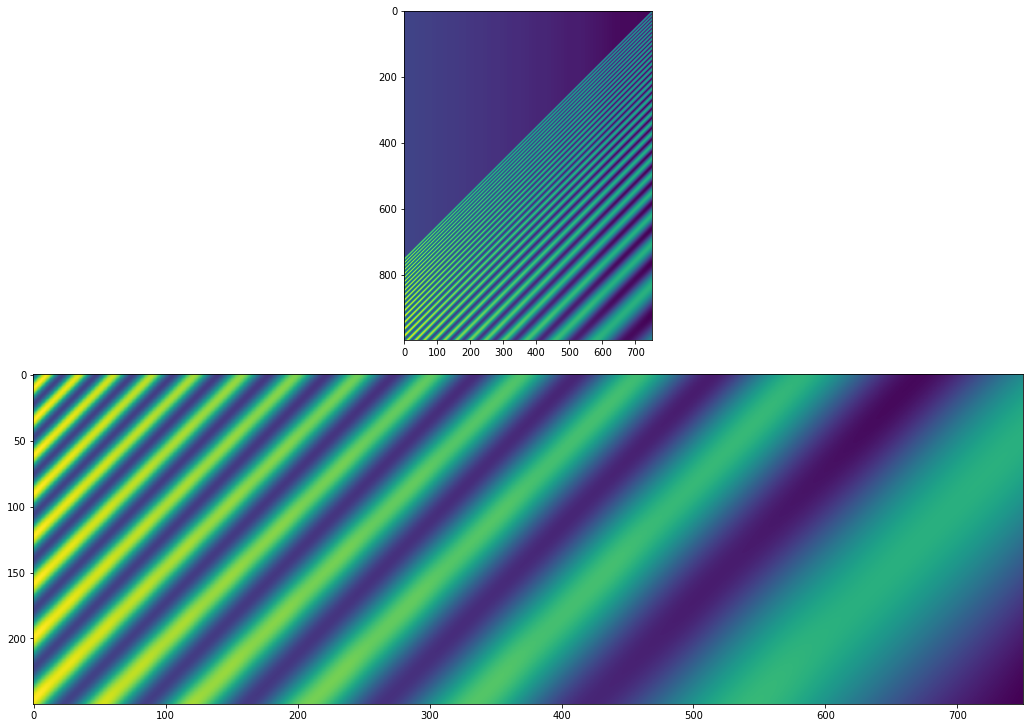

In [81]:
plt.rcParams["figure.figsize"] = (20,10)

fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[1, 0])
f_ax1.imshow(stim_train.squeeze())
f_ax2.imshow(stim_test.squeeze())

# A word on scaling
The SKlearn framework was used to get the mean and variance of the training set. Then, both the training and test set were rescaled by dividing by the training mean and dividing by the standard deviation.
https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/


# CNN model
A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements.

The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.

The model expects as input for each sample in terms of the number of time steps and the number of features.

We are working with a univariate series (simply one measurement over time), so the number of features is one, for one variable.

the number of timesteps if how far we are looking back into the past, here we are looking 15 s into the past. 
So the load_model function expects as argument input_shape, which has the following shape: 
`input_shape=(n_steps, n_features)`

The exact 1D CNN Model for univariate time series forecasting we are using is shown below:

```
inputs = Input(shape=input_shape)
x = Conv1D(neurons, kernel_size=kernel_size, activation='relu',
			   name='conv1')(inputs)

x = MaxPooling1D(name='pool')(x)
x = Dropout(dropout_rate)(x)
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(1, name='fc2')(x)
predictions = Activation('linear')(x)
model = Model(outputs=predictions, inputs=inputs)

if trained:
	model.load_weights(weight_path)

model.compile(optimizer='adam', loss='mse', metrics=[r_square, 'mse'])
```

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape:

```
[samples, timesteps, features]
```

In our case, we have 1125 samples in the train set and 750 timesteps (15 s prior data) and one feature (univariate time series)




In [82]:
# construct the CNN model
# load model with pretrained weights if already trained
filepath = None
if filepath is None:
	model = cnn.create_model.load_model(input_shape)
else:
	model = cnn.create_model.load_model(input_shape, trained=True, weight_path=filepath)



# Remembering the best weights during training
Here we use a checkpoint to save the model weights to the a file, if and only if the mean squared error on the test set improves. The weights are stored in an hdf5 file and can be loaded in the future with 


```
model.load_weights(file_path)
```



In [83]:
if print_summary:
	model.summary()
	plot_model(model, dirs['save'] + 'model.png', show_shapes=True)

es = EarlyStopping(monitor='val_loss', patience=20)

# callbacks
filepath = dirs['save'] + 'weights/weights_best_' + behavior_par + '.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
							save_best_only=True, mode='auto')


# Model fitting
Once the model is defined, we can fit it on the training dataset.

In [87]:
# training
history = model.fit(stim_train, resp_train,
					batch_size=batch_size,
					epochs=epochs,
					validation_data=(stim_test, resp_test),
					callbacks=[checkpoint, es],
					verbose=1)

saved_model = load_model(filepath=filepath,
						 custom_objects={'r_square': r_square})


Epoch 1/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0033 - r_square: 0.9682 - mse: 0.0018 - val_loss: 0.0126 - val_r_square: -1.2745 - val_mse: 0.0112
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - r_square: 0.9686 - mse: 0.0017 - val_loss: 0.0115 - val_r_square: -0.9737 - val_mse: 0.0101
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - r_square: 0.9658 - mse: 0.0018 - val_loss: 0.0089 - val_r_square: -0.4721 - val_mse: 0.0075
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0035 - r_square: 0.9640 - mse: 0.0020 - val_loss: 0.0111 - val_r_square: -0.8967 - val_mse: 0.0098
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0033 - r_square: 0.9675 - mse: 0.0018 - val_loss: 0.0093 - val_r_square: -0.5061 - val_mse: 0.0079
Epoch 6/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0033 - r_square: 0.9665 - mse: 0.0018 - val_loss: 0.01

# Prediction
After the model is fit, we can use it to make a prediction.

We can predict the response to any sequence of stimuli. The model expects the input shape to be three-dimensional with ``` [samples, timesteps, features]```, therefore, we must reshape the single input sample before making the prediction. However, here we will just show the performance on the original train and test sets.

In [88]:
# predict and evaluate
_pred_train = model.predict(stim_train).T[0]
_pred_test = model.predict(stim_test).T[0]

train_accuracy = cnn.utils.evaluator(resp_train, _pred_train)
test_accuracy = cnn.utils.evaluator(resp_test, _pred_test)


# Plot the learned filter weights


(-5.0, 0.0)

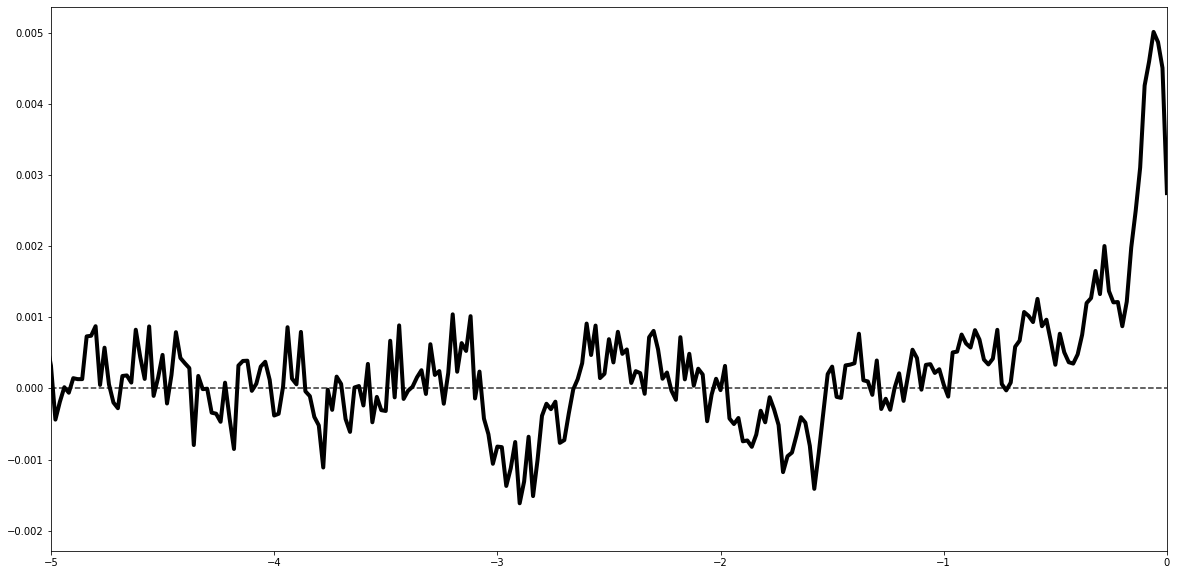

In [89]:
fig, ax = plt.subplots()
cnn.utils.plot_weights(ax, saved_model, 0.02, linewidth=4, color='k')
ax.set_xlim(-5, 0)

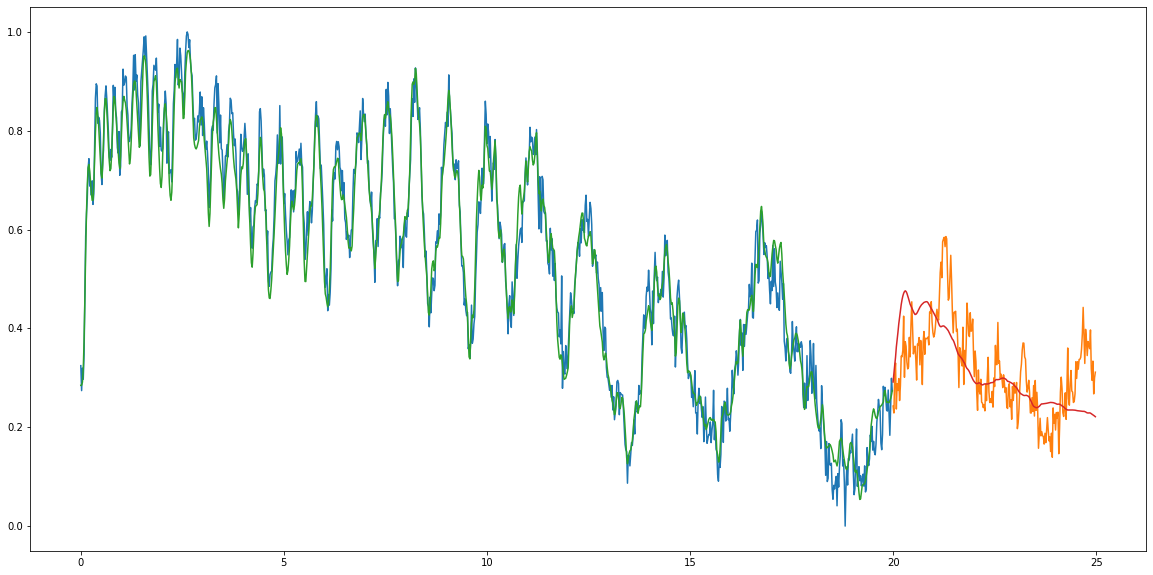

In [90]:
# predict and evaluate
nt_train, nt = len(stim_train), len(stim)
time_train = np.arange(nt_train) * 0.02
time_test = np.arange(nt_train, nt) * 0.02

plt.figure()
_pred_train = saved_model.predict(stim_train)
_pred_test = saved_model.predict(stim_test)
plt.plot(time_train, resp_train.squeeze())
plt.plot(time_test, resp_test.squeeze())
plt.plot(time_train, _pred_train)
plt.plot(time_test, _pred_test)

# Compare prediction error (MSE) with Ridge regression
Now we can compare the performance of 1D CNN with more traditional linear regression methods such as Ridge regression. To find the ridge regression penalty we perform grid search on the ridge alpha value with 5-fold cross-validation.


In [91]:
stim_train, stim_test = stim_train.squeeze(), stim_test.squeeze()
model = Ridge()
alphas = np.logspace(0, 30, num=20, base=2)
param_search = [{'alpha': alphas}]

tscv = TimeSeriesSplit(n_splits=5)
grid_result = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, scoring='neg_mean_squared_error')
grid_result.fit(stim_train, resp_train)
print("Best test mse: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# using this ridge penalty value, get the mse between resp_test and ridge prediction
model = Ridge(alpha=grid_result.best_params_['alpha']).fit(stim_train, resp_train)



Best test mse: -0.015122 using {'alpha': 710.9893850187036}


# compare filters


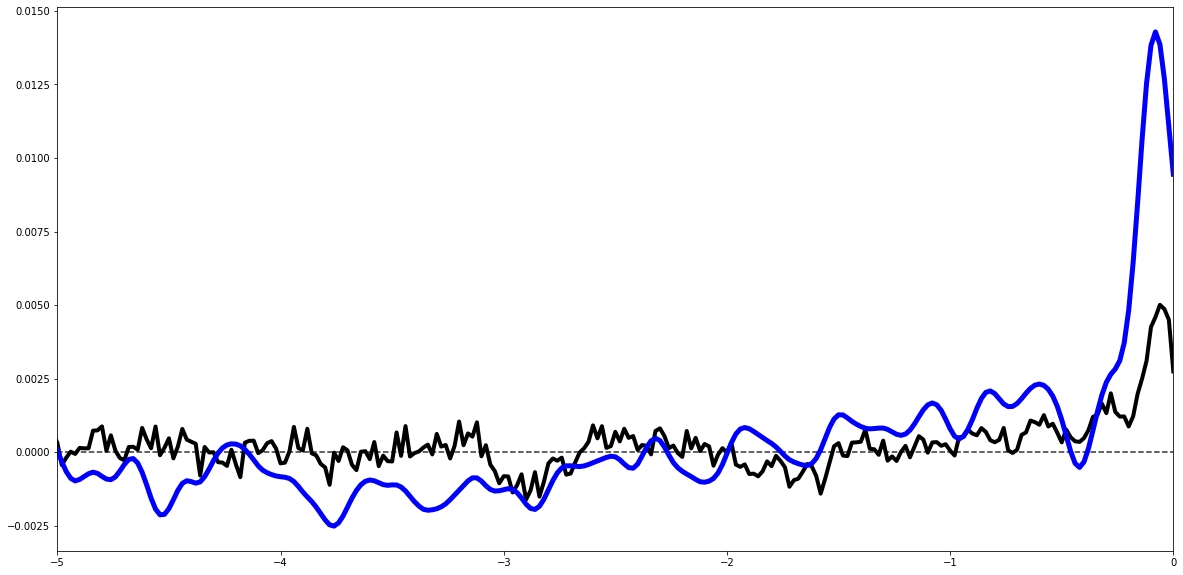

In [92]:
w = model.coef_[0]
d = len(w)
t = np.arange(-d + 1, 1) * 0.02

# compare ridge and CNN filters
fig, ax = plt.subplots()
cnn.utils.plot_weights(ax, saved_model, 0.02, linewidth=4, color='k')
ax.set_xlim(-5, 0)
ax.plot(t, w, 'b', linewidth=5)

# pass the ridge filter though a nonlinearity to make a prediction

In [93]:
xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim, response, w, 0.02, 100)


# plot the actual measurement of the time series with the CNN and ridge predictions


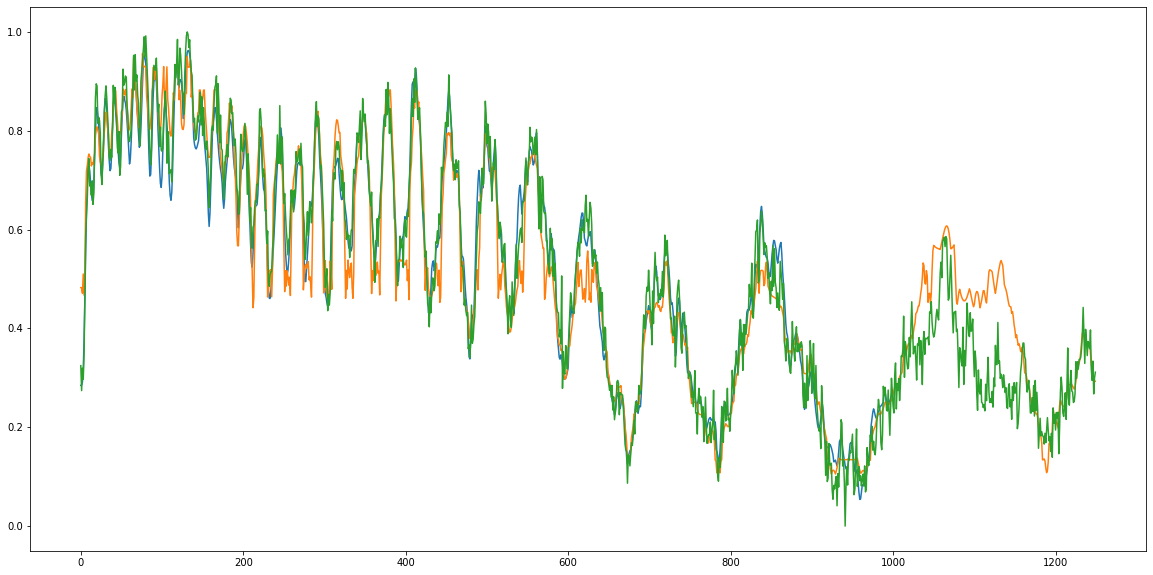

In [94]:
# compare with CNN
plt.plot(response, 'k', linewidth=3, label='actual')
plt.plot(_pred_train, 'c', label='CNN prediction')
plt.plot(fnlin(rawfilteroutput), 'm', label='ridge prediction')
plt.legend()